<a href="https://colab.research.google.com/github/stepan-zykov/DLS/blob/main/AutoEncoder/mnist_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook
from matplotlib.colors import Normalize
import IPython.display as display
from math import ceil

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
os.chdir('/content/drive/MyDrive/DLS/HW/HW7_AutoEncoder/')

In [9]:
os.getcwd()

'/content/drive/MyDrive/DLS/HW/HW7_AutoEncoder'

Загружаем датасет MNIST, преобразуем данные в PyTorch тензоры

In [10]:
batch_size = 60
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [84]:
def compare_pictures_vae(gt, rec):
    """
    Функция получает на вход ихсодные картинки и восстановленные картинки, вытянутые в векторы.
    Выводит соответствующие изображения, одно под другим
    """
    rec = rec.view(-1, 28, 28).cpu().detach().numpy()
    gt = gt.view(-1, 28, 28).cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(8, 3))
    axes = axes.flatten()
    for i, photo in enumerate(np.concatenate([gt, rec])):
        photo = np.clip(photo, 0, 1)
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [85]:
def losses_chart(train_losses, val_losses):
    """
    Функция получает списки лоссов на трейне и валидации и отрисовывает графики
    """
    epoch = len(train_losses)
    plt.plot(range(1, epoch + 1), train_losses, label = 'Training Loss')
    plt.plot(range(1, epoch + 1), val_losses, label = 'Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [86]:
# число признаков в латентном слое
latent_features = 20

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features = 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(in_features=256, out_features = 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, latent_features*2))

        self.decoder = nn.Sequential(
            nn.Linear(latent_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, latent_features)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, mu, log_var):
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        reconstruction = self.decode(mu, log_var)
        return mu, log_var, reconstruction

In [57]:
x = next(iter(train_loader))[0].to(device)

In [58]:
mu, log_var = autoencoder.encode(x)

In [59]:
mu.shape

torch.Size([60, 20])

In [26]:
def KL_divergence(mu, log_var):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, log_var, reconstruction):
    return (KL_divergence(mu, log_var) + log_likelihood(x, reconstruction))/2/28/28

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [28]:
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=10):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    train_losses, val_losses = [], []
    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, (X_batch, _ ) in enumerate(train_loader):
            X_batch = X_batch.float().to(device)
            optimizer.zero_grad()
            mu, log_var, reconstruction = model(X_batch)
            loss = loss_fn(X_batch.view(-1, 28*28), mu, log_var, reconstruction) # x, mu, log_var, reconstruction
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
          for X_batch, _ in val_loader:
              X_batch = X_batch.float().to(device)
              mu, log_var, reconstruction = model(X_batch)
              loss = loss_fn(X_batch.view(-1, 28*28), mu, log_var, reconstruction)
              val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        display.clear_output(wait=True) # clear previous output
        for i in range(0, 11, 5):
            compare_pictures_vae(X_batch[i:i+5], reconstruction[i:i+5])
        losses_chart(train_losses, val_losses)
        print(f"Epoch [{epoch + 1}/{n_epochs}],",
              f"\nTraining loss: {np.mean(train_losses_per_epoch):.4f},",
              f"\nValidation loss: {np.mean(val_losses_per_epoch):.4f}")

    return train_losses, val_losses

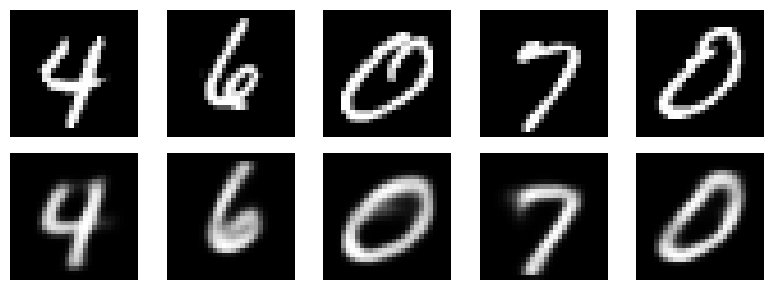

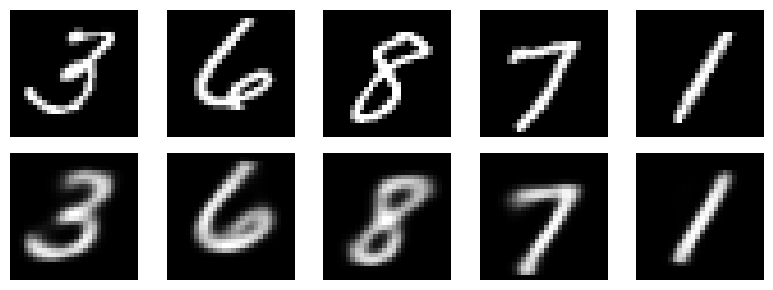

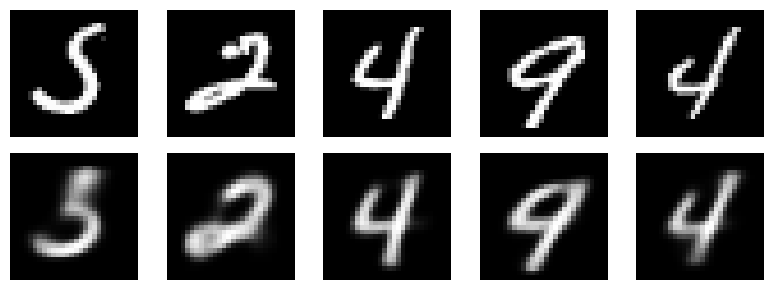

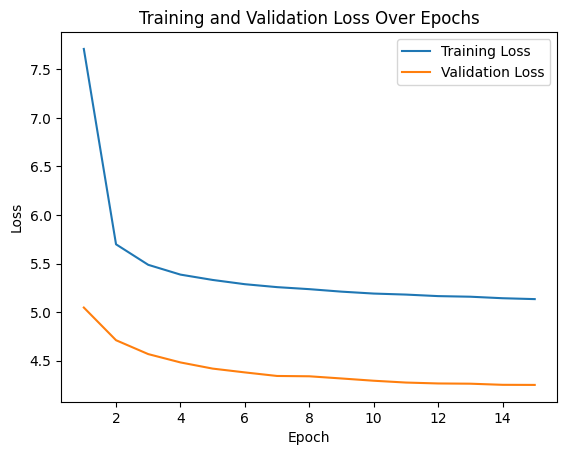

Epoch [15/15], 
Training loss: 5.1336, 
Validation loss: 4.2501


In [29]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, train_loader, val_loader, 15)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

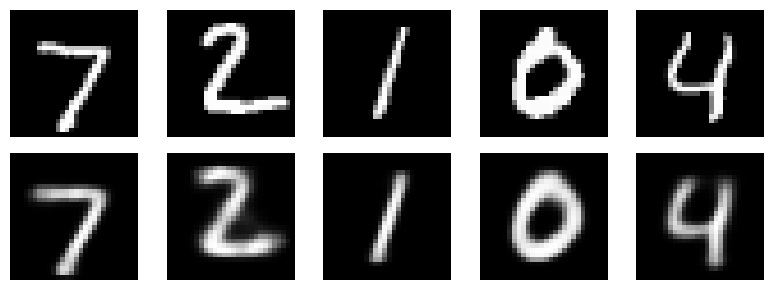

In [35]:
autoencoder.eval()
with torch.no_grad():
    for X_batch, y in val_loader:
        X_batch = X_batch[:5]
        X_batch = X_batch.float().to(device)
        mu, log_var, reconstruction = autoencoder(X_batch)
        compare_pictures_vae(X_batch, reconstruction)
        break

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [72]:
mu = torch.tensor(np.array([np.random.normal(0, 1, latent_features) for i in range(10)])).float().to(device)

In [73]:
# в режиме eval log_var не учитывается, аоэтому инициализируем переменную случайными числами
log_var = torch.tensor(np.random.rand(10, latent_features)).float().to(device)

In [82]:
def show_pictures(pictures):
    rows = ceil(len(pictures)/5)
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.flatten()
    for i, photo in enumerate(pictures):
        photo = photo.view(28, 28)
        photo = photo.detach().cpu()
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

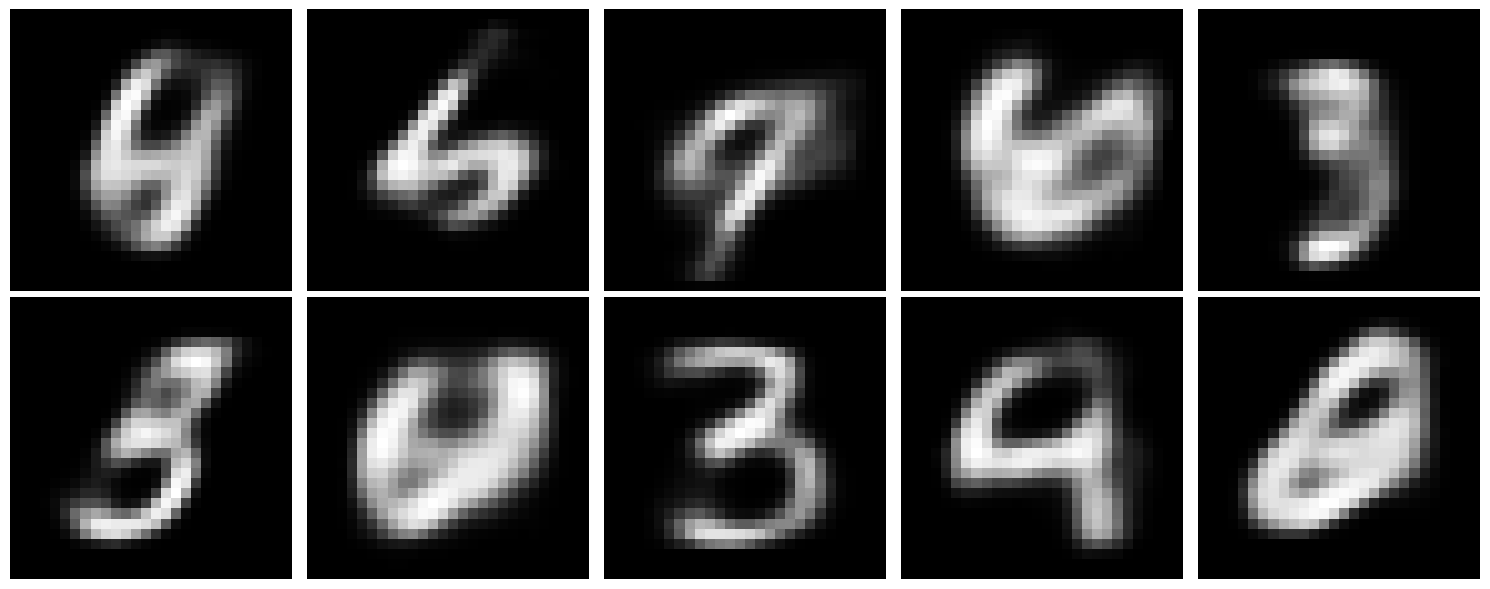

In [83]:
generated_pictures = autoencoder.decode(mu, log_var)
show_pictures(generated_pictures)
